# Llama

![](https://ucarecdn.com/05af6071-73b2-4067-9a39-632fcb2f24e9/)


Llama 1 вышла в феврале 2023 года. Это уже подальше, чем GPT-2. И в ее архитектуре появилось уже больше серьезных изменений:

- Нормализация RMSNorm (вместе с pre-norm).
- Функция активации SwiGLU.
- Новый способ кодирования позиций — Rotary Positional Embeddings.

# RMSNorm

![2\_rmsnorm.png](https://ucarecdn.com/2975a217-27ff-4d26-b4a1-cc48a8de1e45/)

В Llama используется более быстрая и эффективная нормализация — **RMSNorm (Root Mean Square Normalization)**.
И, также как в GPT-2, используется *pre-norm* нормализация, то есть слои нормализации располагаются **перед блоками внимания и FNN**.

RMSNorm отличается от обычной нормализации только одним: в нём исключен этап центрирования (вычитание среднего) и используется только масштабирование по RMS.
Это сокращает вычислительные затраты (на 7–64%) без существенной потери качества.
На картинке показана разница в распределении после применения RMSNorm и LayerNorm к исходным данным — RMSNorm не разбросан вокруг нуля.

<p align="center">
  <img src="https://ucarecdn.com/cbfbb78e-e2b0-40e2-ba56-73e5114d54f6/" width="350" alt="RMSNorm vs LayerNorm">
</p>

## Этапы вычисления RMSNorm

1. **Вычисление среднеквадратичного значения:**

   $$\text{RMS}(\mathbf{x}) = \sqrt{\frac{1}{d} \sum_{j=1}^{d} x_j^2}$$

2. **Нормализация входящего вектора:**

   $$\hat{x}_i = \frac{x_i}{\text{RMS}(\mathbf{x})}$$

3. **Применение масштабирования:**

   $$y_i = w_i \cdot \hat{x}_i$$

---

**Где:**

* $x_i$ — *i*-й элемент входящего вектора.
* $w_i$ — *i*-й элемент обучаемого вектора весов.
  Использование весов позволяет модели адаптивно регулировать амплитуду признаков.
  Без них нормализация была бы слишком «жёсткой» и могла бы ограничить качество модели.
* $d$ — размерность входящего вектора.
* $\varepsilon$ — малая константа (например, 1e-6), предотвращает деление на ноль.

---

Так как на вход подаётся тензор, то в векторной форме RMSNorm вычисляется так:

$$
RMSNorm(x) = w ⊙ \frac{x}{\sqrt{mean(x^2) + ϵ}}
$$

**Где:**

* $x$ — входящий тензор размера `batch_size × ...`



In [19]:
import torch
from torch import nn

class RMSNorm(nn.Module):
    def __init__(self, dim: int, eps: float = 1e-6):
        super().__init__()
        self._eps = eps
        self._w = nn.Parameter(torch.ones(dim))
    
    def forward(self, x: torch.Tensor): # [batch_size × seq_len × emb_size]
        rms = (x.pow(2).mean(-1, keepdim=True) + self._eps) ** 0.5
        norm_x = x / rms
        return self._w * norm_x

# SwiGLU

![3\_swiglu.png](https://ucarecdn.com/120dea77-2bf2-455f-9b54-c35c4efddc9e/)

В **Llama** ввели новую функцию активации — **SwiGLU (Swish-Gated Linear Unit)** — это гибридная функция активации, которая представляет собой комбинацию трёх линейных преобразований и функции активации **SiLU (Sigmoid Linear Unit)**, она же *Swish* в терминологии Google.

Формула SwiGLU выглядит так:

$$
\text{SwiGLU}(x) = \text{down}(\text{SiLU}(\text{gate}(x)) \otimes \text{up}(x))
$$

где:

* $x$ — входящий тензор.
* $\text{gate}(x)$ — линейный слой для гейтового механизма. Преобразует вход `x` размерностью `emb_size` в промежуточное представление размерности `4 * emb_size`.
* $\text{up}(x)$ — линейный слой для увеличения размерности. Также преобразует `x` в размерность `4 * emb_size`.
* $\text{SiLU}(x) = x \cdot \sigma(x)$ — функция активации, где $\sigma$ — сигмоида.
* $\otimes$ — поэлементное умножение.
* $\text{down}(x)$ — линейный слой для уменьшения промежуточного представления до исходного размера (`emb_size`).

> **Гейтинг** (от слова *gate* — «врата») — это механизм, который позволяет сети динамически фильтровать, какая информация должна проходить дальше.
> При гейтинге создаются как бы два независимых потока:
>
> * один предназначен для прямой передачи информации (*up-down*),
> * другой — для контроля передаваемой информации (*gate*).
>
> Это позволяет сети учить более сложные паттерны.
> Например, гейт может научиться:
> «если признак A активен, то пропусти признак B»,
> что невозможно с простой функцией активации между линейными слоями.
>
> Также гейтинг помогает с затуханием градиентов: вместо простого обнуления (как в ReLU), гейт может тонко модулировать силу сигнала.

SwiGLU более сложная (дорогая), чем ReLU/GELU, так как требует больше вычислений (три линейных преобразования вместо двух).
Но при этом показывает лучшее качество по сравнению с ReLU и GELU.

График **SiLU** похож на **GELU**, но более гладкий:

<p align="center">
  <img src="https://ucarecdn.com/6683e0c8-96b7-4389-826a-a73708b4a835/" width="500" alt="SiLU vs GELU">
</p>


In [20]:
import torch
from torch import nn
import torch.nn.functional as F

class SiLU(nn.Module):
    def forward(self, x: torch.Tensor): # [batch_size × seq_len × emb_size]
        return torch.sigmoid(x) * x

## SwiGLU

In [21]:
import torch
from torch import nn

class SwiGLU(nn.Module):
    def __init__(self, emb_size: int, dropout: float = 0.1):
        super().__init__()

        self._gate = nn.Linear(emb_size, 4 * emb_size)
        self._up = nn.Linear(emb_size, 4 * emb_size)
        self._down = nn.Linear(4 * emb_size, emb_size)
        self._activation = SiLU()
        self._dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor): # [batch_size × seq_len × emb_size].
        gate_out = self._gate(x)                          # [batch, seq, 4*emb]
        activation_out = self._activation(gate_out)       # [batch, seq, 4*emb]
        up_out = self._up(x)                              # [batch, seq, 4*emb]
        out = up_out * activation_out                     # поэлементное!
        out = self._down(out)                             # [batch, seq, emb]
        return self._dropout(out)

        

# RoPE

Вот мы и добрались до наиболее серьезного изменения в архитектуре: обычные позиционные эмбеддинги в **Llama** были заменены на **Rotary Positional Embeddings (RoPE)**.

**GPT-1** получал информацию о позициях токенов путем сложения эмбеддингов токенов и позиционных эмбеддингов.
**RoPE** же кодирует позиции токенов с помощью *вращения (rotation)* векторов **запроса (query)** и **ключа (key)** в двумерном пространстве. При этом каждая позиция в последовательности получает уникальный поворот, а угол поворота зависит от расположения токена в последовательности.

Если упрощенно, то выглядит это так:

* Слово на позиции **1**: поворот на 1°
* Слово на позиции **2**: поворот на 2°
* Слово на позиции **100**: поворот на 100°
* Слово на позиции **101**: поворот на 101°

Угол между 1 и 101 словом будет достаточно большим — **100°**, что отражает большую дистанцию между ними.
А разница между 100 и 101 словом будет такой же как между 1 и 2, тем самым показывая одинаковую дистанцию между ними.

Такое относительное кодирование позволяет модели лучше понимать расстояние между токенами.

<p align="center">
  <img src="https://ucarecdn.com/26cd6249-bb93-4a26-9670-8d3847d9db4d/" width="400" alt="RoPE rotation illustration">
</p>

В последующем тензоры **запроса (query)** и **ключа (key)** перемножаются для вычисления **матрицы внимания**.
А это означает, что теперь вычисление внимания напрямую зависит от относительных позиций слов.

---

## Почему RoPE лучше

* **Устойчивость к сдвигу:** модель не переобучается на конкретных позициях в обучающих данных, так как учитывает относительные расстояния.
* **Экономия:** интегрируется в ключи (*key*) и запросы (*query*) посредством матричных вычислений, без необходимости создавать и хранить отдельный слой для позиционных эмбеддингов.
* **Экстраполяция:** модель может работать с последовательностями длиннее, чем видела при обучении — потому что она выучивает закономерности поворотов в зависимости от дистанции.


### Как это работает...

Основная идея: для каждого токена в последовательности его эмбеддинг поворачивается на угол, зависящий от позиции токена и фиксированных частот.

На вход к нам поступают либо тензор ключа (key), либо тензор запроса (query) размерностью `head_size`.
Обозначим его как *x*.

<p align="center">
  <img src="https://ucarecdn.com/c6d62324-a062-4be7-943c-36cf16b5a424/" alt="rope_0_1.png" width="250" height="127" />
</p>

Каждая строка в тензоре — это вектор, соответствующий одному токену в последовательности.
Обозначим вектор как *xₘ*, где *m* — номер позиции токена.

<p align="center">
  <img src="https://ucarecdn.com/8eb58921-02ef-4235-856d-e4cabd691f22/" alt="rope_0_2.png" width="400" height="99" />
</p>

Вращать вектор мы будем в двумерном пространстве. Но размерность вектора многомерная!
Чтобы свести вращение к двумерному пространству, вектор разбивают на рядом стоящие пары измерений:

$$
x_m = [x_{m0}, x_{m1}, x_{m2}, x_{m3}, …, x_{m(d−2)}, x_{m(d−1)}] \Rightarrow \text{пары: } (x_{m0}, x_{m1}), (x_{m2}, x_{m3}), …, (x_{m(d−2)}, x_{m(d−1)})
$$

> Из-за того, что вектор обязательно должен быть разбит на пары, RoPE может работать только для четных `head_size`.

После этого мы можем рассматривать каждую пару
$(x_{m,2k}; x_{m,2k+1})$
как вектор в двумерном пространстве:

$$
\begin{bmatrix}
x_{m,2k} \
x_{m,2k+1}
\end{bmatrix}
$$

А раз это вектор в двумерном пространстве, то мы можем повернуть его на угол
$m \cdot \theta_k$.






Каждая пара измерений вектора поворачивается на угол:

$$
m \cdot \theta_k
$$

<p align="center">
  <img src="https://ucarecdn.com/f4eca185-7e82-43e8-a796-c88482fee36f/" alt="rope_0_3.png" width="150" height="109">
</p>

Здесь
$ \theta_k $ — это частота вращения, которая вычисляется по формуле:

$$
\theta_k = \frac{1}{base^{2k/d}}
$$

где:

* **base** — гиперпараметр (обычно = 10 000),
* **k** — индекс пары (от 0 до `d/2 - 1`),
* **d** — размерность вектора (`head_size`) запроса (*query*) в каждой голове, каждого блока внимания.


Само вращение выполняется с помощью матрицы:

$$
R(m, \theta_k) =
\begin{bmatrix}
\cos(m \theta_k) & -\sin(m \theta_k) \\
\sin(m \theta_k) & \cos(m \theta_k)
\end{bmatrix}
$$

Для этого каждая пара
($x_{m,2k}$; $x_{m,2k+1}$)
перемножается на матрицу поворота:



$$
\begin{bmatrix} 
x_{m,2k}' \\ 
x_{m,2k+1}' 
\end{bmatrix}
= 
R(m, \theta_k) \cdot 
\begin{bmatrix} 
x_{m,2k} \\ 
x_{m,2k+1} 
\end{bmatrix}
$$

$$
\begin{bmatrix} 
x_{m,2k}' \\ 
x_{m,2k+1}' 
\end{bmatrix}
= 
\begin{bmatrix} 
\cos(m \theta_k) & -\sin(m \theta_k) \\ 
\sin(m \theta_k) & \cos(m \theta_k) 
\end{bmatrix} 
\cdot 
\begin{bmatrix} 
x_{m,2k} \\ 
x_{m,2k+1} 
\end{bmatrix}
$$

$$
\begin{bmatrix} 
x_{m,2k}' \\ 
x_{m,2k+1}' 
\end{bmatrix}
= 
\begin{bmatrix} 
x_{m,2k} \cdot \cos(m \theta_k) - x_{m,2k+1} \cdot \sin(m \theta_k) \\ 
x_{m,2k} \cdot \sin(m \theta_k) + x_{m,2k+1} \cdot \cos(m \theta_k) 
\end{bmatrix}
$$

Где:

* $R(m, \theta_k)$ — это стандартная матрица вращения в 2D пространстве. Взята из классической линейной алгебры.
* $\theta_k$ — частота вращения для $k$-й пары измерений.
* $m$ — позиция токена в последовательности.
* $k$ — индекс пары измерений.
* $x_{m,2k}$ и $x_{m,2k+1}$ — четное и нечетное измерение вектора.
* $x_{m,2k}'$ и $x_{m,2k+1}'$ — четное и нечетное измерение вектора после вращения.

И так происходит с каждым вектором ключа (*key*) или запроса (*query*) в каждой голове, каждого блока внимания.

---

**Примечание**

Обратите внимание, что разные вектора и их составляющие вращаются с разной «скоростью».
Угол поворота зависит от позиции токена $m$, и позиции пары $k$.

$$
m \cdot \theta_k = m \cdot \frac{1}{base^{-2k/d}}
$$

---

Вот для примера сводная таблица для разных значений $m$ и $k$:

| Позиция $m$ | $k=0$   | $k=1$  | $k=2$ | $k=3$  |
| ----------- | ------- | ------ | ----- | ------ |
| 0           | 0°      | 0°     | 0°    | 0°     |
| 1           | 1.0°    | 0.1°   | 0.01° | 0.001° |
| 10          | 10.0°   | 1.0°   | 0.1°  | 0.01°  |
| 100         | 100.0°  | 10.0°  | 1.0°  | 0.1°   |
| 1000        | 1000.0° | 100.0° | 10.0° | 1.0°   |



- $m$ напрямую и линейно масштабирует угол: чем больше $m$, тем больше угол поворота.
- $k$ делает наоборот: чем больше $k$, тем меньше угол.
И уменьшается он экспоненциально с ростом $k$.

Такое неравномерное распределение создает уникальный паттерн для каждого вектора,
что позволяет модели лучше различать **относительные позиции**.

In [22]:
def create_rotary_embeddings(head_size, max_seq_len, base=10000):
    """
    Создает матрицы косинусов и синусов для RoPE.
    
    Returns:
        cos_matrix: [max_seq_len, head_size//2]
        sin_matrix: [max_seq_len, head_size//2]
    """
    # Обратные частоты
    freqs = 1.0 / (base ** (2 * torch.arange(head_size // 2) / head_size))
    
    # Позиции
    positions = torch.arange(max_seq_len)
    
    # Матрица частот (внешнее произведение)
    freq_matrix = torch.outer(positions, freqs)
    
    # Матрицы косинусов и синусов
    cos_matrix = torch.cos(freq_matrix)
    sin_matrix = torch.sin(freq_matrix)
    
    return cos_matrix, sin_matrix

# Использование
head_size = 64
max_seq_len = 512

cos_m, sin_m = create_rotary_embeddings(head_size, max_seq_len)
print(f"cos shape: {cos_m.shape}")  # torch.Size([512, 32])
print(f"sin shape: {sin_m.shape}")  # torch.Size([512, 32])

cos shape: torch.Size([512, 32])
sin shape: torch.Size([512, 32])


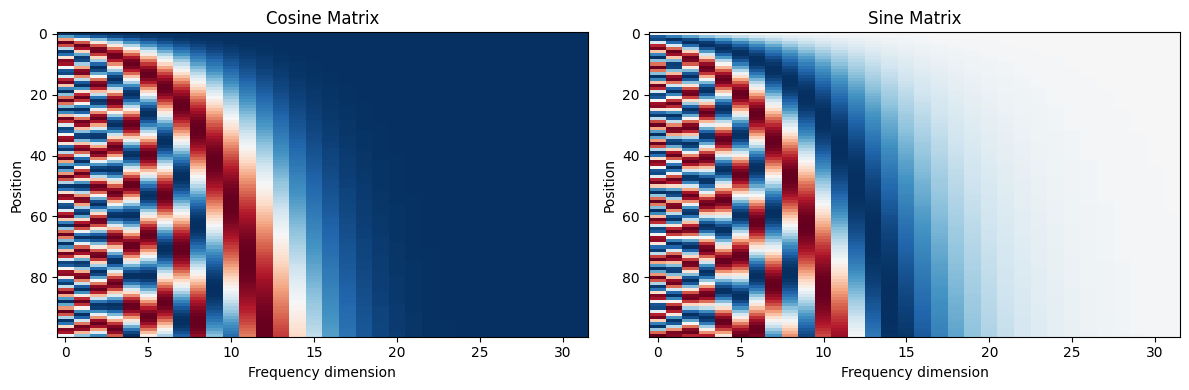

In [23]:
import matplotlib.pyplot as plt

cos_m, sin_m = create_rotary_embeddings(64, 100)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.imshow(cos_m.numpy(), aspect='auto', cmap='RdBu')
ax1.set_title('Cosine Matrix')
ax1.set_xlabel('Frequency dimension')
ax1.set_ylabel('Position')

ax2.imshow(sin_m.numpy(), aspect='auto', cmap='RdBu')
ax2.set_title('Sine Matrix')
ax2.set_xlabel('Frequency dimension')
ax2.set_ylabel('Position')
plt.tight_layout()

In [24]:
import torch
from torch import nn

class RoPE(nn.Module):
    def __init__(self, head_size: int, max_seq_len: int, base: int = 10_000):
        super().__init__()
        assert head_size % 2 == 0, "head_size должен быть четным"

        # Обратные частоты
        freqs = 1.0 / (base ** (2 * torch.arange(head_size // 2).float() / head_size))
        
        # Позиции
        positions = torch.arange(max_seq_len).float()
        
        # Матрица частот (внешнее произведение)
        #freq_matrix = torch.outer(positions, freqs)
        freq_matrix = positions.unsqueeze(1) * freqs.unsqueeze(0)

        # Матрицы косинусов и синусов
        self.register_buffer('cos_matrix', torch.cos(freq_matrix))
        self.register_buffer('sin_matrix', torch.sin(freq_matrix))


    def forward(self, x: torch.Tensor, start_pos: int = 0): # Получает на вход тензор x (тип float) размером [batch_size × seq_len × head_size]
        batch_size, seq_len, emb_size = x.shape

        # Берем нужную часть матриц и приводим к типу x
        cos = self.cos_matrix[start_pos:start_pos+seq_len].to(x.dtype)  # [seq_len, head_size//2]
        sin = self.sin_matrix[start_pos:start_pos+seq_len].to(x.dtype)  # [seq_len, head_size//2]
        

        # Разделяем на четные и нечетные
        x_even = x[:, :, 0::2]  # [batch_size, seq_len, head_size//2]
        x_odd = x[:, :, 1::2]   # [batch_size, seq_len, head_size//2]

        # Применяем поворот
        x_rotated_even = x_even * cos - x_odd * sin
        x_rotated_odd = x_even * sin + x_odd * cos


        # Объединяем обратно
        x_rotated = torch.stack([x_rotated_even, x_rotated_odd], dim=-1)
        x_rotated = x_rotated.flatten(-2)  # [batch_size, seq_len, head_size]

        return x_rotated

In [25]:
import torch
from torch import nn
import torch.nn.functional as F
from math import sqrt
import torch
from torch import nn
from torch import Tensor

class TokenEmbeddings(nn.Module):
    def __init__(self, vocab_size: int, emb_size: int):
        super().__init__()
        self._embedding = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=emb_size
        )

    def forward(self, x: Tensor) -> Tensor:
        return self._embedding(x)

    @property
    def num_embeddings(self) -> int:
        return self._embedding.num_embeddings

    @property
    def embedding_dim(self) -> int:
        return self._embedding.embedding_dim
    
    
class HeadAttention(nn.Module):

    def __init__(self, emb_size: int, head_size: int, max_seq_len: int, rope: RoPE):
        super().__init__()
        self._emb_size = emb_size
        self._head_size = head_size
        self._max_seq_len = max_seq_len
        self._rope = rope

        self._k = nn.Linear(emb_size, head_size)
        self._q = nn.Linear(emb_size, head_size)
        self._v = nn.Linear(emb_size, head_size)

        mask = torch.tril(torch.ones(max_seq_len, max_seq_len))
        self.register_buffer('_tril_mask', mask.bool() if hasattr(torch, 'bool') else mask.byte())

    def forward(self, x: torch.Tensor, use_cache: bool = True, cache: tuple = None) -> tuple:
        #seq_len = x.shape[1]
        batch_size, seq_len, emb_size = x.shape

        if seq_len > self._max_seq_len:
            raise ValueError(f"Длина последовательности {seq_len} превышает максимум {self._max_seq_len}")

        k = self._k(x)  # [B, T, hs]
        q = self._q(x)  # [B, T, hs]
        v = self._v(x)  # [B, T, hs]

        start_pos = 0
        if cache is not None:
            k_cache, v_cache = cache
            cache_len = k_cache.shape[1]
            start_pos = cache_len

        # ✅ Применяем RoPE к Q и K (НЕ к V!)
        q = self._rope(q, start_pos=start_pos)  # [B, T, hs]
        k = self._rope(k, start_pos=start_pos)  # [B, T, hs]

        if cache is not None:
            k_cache, v_cache = cache
            k = torch.cat([k_cache, k], dim=1)  # [B, cache_len + T, hs]
            v = torch.cat([v_cache, v], dim=1)  # [B, cache_len + T, hs]
        
        scores = q @ k.transpose(-2, -1) / sqrt(self._head_size)
        
        if cache is None:
            scores = scores.masked_fill(~self._tril_mask[:seq_len, :seq_len], float('-inf'))
        
        weights = F.softmax(scores, dim=-1)
        x_out = weights @ v  # [B, T, hs]

        if use_cache is True:
            return (x_out, (k, v))
        else:
            return (x_out, None)
        
from torch import nn
import torch
import math

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads: int, emb_size: int, head_size: int, max_seq_len: int, rope: RoPE, dropout: float = 0.1):

        super().__init__()
        self._heads = nn.ModuleList([
            HeadAttention(
                emb_size=emb_size, 
                head_size=head_size, 
                max_seq_len=max_seq_len,
                rope=rope,
            ) for _ in range(num_heads)
        ])
        self._layer = nn.Linear(head_size * num_heads, emb_size)
        self._dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None, use_cache: bool = True, cache: list = None):

        attention_results = []
        for i, head in enumerate(self._heads):
            head_cache = cache[i] if cache is not None else None
            result = head(x, use_cache=use_cache, cache=head_cache)
            attention_results.append(result)
        
        outputs, caches = zip(*attention_results)
        attention_outputs = list(outputs)
        kv_caches = list(caches)
 
        concatenated_attention = torch.cat(attention_outputs, dim=-1)

        projected_output = self._layer(concatenated_attention)
        
        final_output = self._dropout(projected_output)
        
        if use_cache is True:
            return (final_output, kv_caches)
        else:
            return (final_output, None)


class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        self.sqrt_2_over_pi = torch.sqrt(torch.tensor(2.0) / math.pi)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return 0.5 * x * (1 + torch.tanh(
            self.sqrt_2_over_pi * (x + 0.044715 * torch.pow(x, 3))
        ))

    
class Decoder(nn.Module):
    def __init__(self, 
        num_heads: int,
        emb_size: int,
        head_size: int,
        max_seq_len: int,
        rope: RoPE,
        dropout: float = 0.1
    ):
        super().__init__()
        self._heads = MultiHeadAttention(
            num_heads=num_heads, 
            emb_size=emb_size, 
            head_size=head_size, 
            max_seq_len=max_seq_len,
            rope=rope,
            dropout=dropout
        )
        self._ff = SwiGLU(emb_size=emb_size, dropout=dropout)
        self._norm1 = RMSNorm(emb_size)
        self._norm2 = RMSNorm(emb_size)

    def forward(self, x: torch.Tensor, mask: torch.Tensor = None, use_cache: bool = True, cache: list = None) -> torch.Tensor:
        norm1_out = self._norm1(x)
        attention, kv_caches = self._heads(norm1_out, mask, use_cache=use_cache, cache=cache)
        out = attention + x
        
        norm2_out = self._norm2(out)
        ffn_out = self._ff(norm2_out)

        if use_cache is True:
            return (ffn_out + out, kv_caches)
        else:
            return (ffn_out + out, None)



from torch import nn
import torch
import torch.nn.functional as F

class Llama(nn.Module):
    def __init__(self,
        vocab_size: int,
        max_seq_len: int,
        emb_size: int,
        num_heads: int,
        head_size: int,
        num_layers: int,
        dropout: float = 0.1,
        device: str = 'cpu'
    ):
        super().__init__()
        self._vocab_size = vocab_size
        self._max_seq_len = max_seq_len
        self._emb_size = emb_size
        self._num_heads = num_heads
        self._head_size = head_size
        self._num_layers = num_layers
        self._dropout = dropout
        self._device = device
        
        self.validation_loss = None

        # Инициализация слоев
        self._token_embeddings = TokenEmbeddings(
            vocab_size=vocab_size, 
            emb_size=emb_size
        )
        self._position_embeddings = RoPE(
            head_size=head_size,
            max_seq_len=max_seq_len
        )
        #self._position_embeddings = PositionalEmbeddings(
        #    max_seq_len=max_seq_len, 
        #    emb_size=emb_size
        #)
        self._dropout = nn.Dropout(dropout)
        self._decoders = nn.ModuleList([Decoder(
            num_heads=num_heads,
            emb_size=emb_size,
            head_size=head_size,
            max_seq_len=max_seq_len,
            rope=self._position_embeddings,
            dropout=dropout 
        ) for _ in range(num_layers)])
        self._norm = RMSNorm(emb_size)
        self._linear = nn.Linear(emb_size, vocab_size)

    def forward(self, x: torch.Tensor, use_cache: bool = True, cache: list = None) -> tuple:
        # Проверка длины последовательности (только при отсутствии кэша)
        if cache is None and x.size(1) > self._max_seq_len:
            raise ValueError(f"Длина последовательности {x.size(1)} превышает максимальную {self.max_seq_len}")
        
        
        # Вычисление start_pos из кэша (если кэш передан)
        #if cache is not None:
        #    # При кэше обрабатываем только один токен (последний)
        #    seq_len = 1
        #    # Вычисляем start_pos из самого нижнего уровня кэша
        #    if cache and cache[0] and cache[0][0]:
        #        key_cache, _ = cache[0][0]  # Первый декодер, первая голова
        #        start_pos = key_cache.size(1)  # cache_len
        #    else:
        #        start_pos = 0
        #else:
        #    # Без кэша работаем как раньше
        #    start_pos = 0
        #    seq_len = x.size(1)

        # Эмбеддинги токенов и позиций
        tok_out = self._token_embeddings(x)  # [batch, seq_len, emb_size]
       #pos_out = self._position_embeddings(x)  # [batch, seq_len, emb_size]
        
        # Комбинирование
        out = self._dropout(tok_out)  # [batch, seq_len, emb_size]
        
        # Стек декодеров с передачей кэша
        new_cache = []
        for i, decoder in enumerate(self._decoders):
            decoder_cache = cache[i] if cache is not None else None
            decoder_result = decoder(out, use_cache=use_cache, cache=decoder_cache)

            # Извлекаем результат из кортежа
            if use_cache:
                out, decoder_new_cache = decoder_result
                new_cache.append(decoder_new_cache)
            else:
                out = decoder_result[0]

        out = self._norm(out)
        logits = self._linear(out)
            
        # Возвращаем результат с учетом use_cache
        if use_cache:
            return (logits, new_cache)
        else:
            return (logits, None)

    def generate(self,
        x: torch.Tensor, 
        max_new_tokens: int, 
        do_sample: bool,
        temperature: float = 1.0,
        top_k: int = None,
        top_p: float = None,
        use_cache: bool = True
    ) -> torch.Tensor:
        cache = None

        for _ in range(max_new_tokens):
            if use_cache and cache is not None:
                # Используем кэш - передаем только последний токен
                x_input = x[:, -1:]  # [batch_size, 1]
            else:
                # Первая итерация или кэш отключен - передаем всю последовательность
                x_input = x
            
            # Прямой проход с кэшем
            logits, new_cache = self.forward(x_input, use_cache=use_cache, cache=cache)
            
            # Обновляем кэш для следующей итерации
            if use_cache:
                cache = new_cache

            last_logits = logits[:, -1, :]  # [batch_size, vocab_size]

            # Масштабируем логиты температурой
            if temperature > 0:
                logits_scaled = last_logits / temperature
            else:
                logits_scaled = last_logits

            if do_sample == True and top_k != None:
                _, topk_indices = torch.topk(logits_scaled, top_k, dim=-1)

                # # Заменим все НЕ top-k логиты на -inf
                masked_logits = logits_scaled.clone()
                vocab_size = logits_scaled.size(-1)

                # создаём маску: 1, если токен НЕ в topk_indices
                mask = torch.ones_like(logits_scaled, dtype=torch.uint8)
                mask.scatter_(1, topk_indices, 0)  # 0 там, где top-k индексы
                masked_logits[mask.byte()] = float('-inf')

                logits_scaled = masked_logits

            if do_sample == True and top_p != None:
                # 1. Применим softmax, чтобы получить вероятности:
                probs = F.softmax(logits_scaled, dim=-1)  # [B, vocab_size]
                # 2. Отсортируем токены по убыванию вероятностей:
                sorted_probs, sorted_indices = torch.sort(probs, descending=True, dim=-1)
                # 3. Посчитаем кумулятивную сумму вероятностей:
                cum_probs = torch.cumsum(sorted_probs, dim=-1)  # [B, vocab_size]
                # 4. Определим маску: оставить токены, пока сумма < top_p
                sorted_mask = (cum_probs <= top_p).byte()  # [B, vocab_size]
                # Гарантируем, что хотя бы первый токен останется
                sorted_mask[:, 0] = 1
                # 5. Преобразуем маску обратно в оригинальный порядок:
                # Создаём полную маску из 0
                mask = torch.zeros_like(probs, dtype=torch.uint8)
                # Устанавливаем 1 в местах нужных токенов
                mask.scatter_(dim=1, index=sorted_indices, src=sorted_mask)
                # 6. Зануляем логиты токенов вне топ-p:
                logits_scaled[~mask] = float('-inf')

            # 4. Применяем Softmax
            probs = F.softmax(logits_scaled, dim=-1)  # [batch_size, vocab_size]


            if do_sample == True:
                # 5. Если do_sample равен True, то отбираем токен случайно с помощью torch.multinomial
                next_token = torch.multinomial(probs, num_samples=1)  # [batch_size, 1]
            else:
                # 5. Если do_sample равен False, то выбираем токен с максимальной вероятностью
                next_token = torch.argmax(probs, dim=-1, keepdim=True)  # [batch_size, 1]
            
            # 6. Добавляем его к последовательности
            x = torch.cat([x, next_token], dim=1)  # [batch_size, seq_len+1]
        return x

    def save(self, path):
        torch.save({
            'model_state_dict': self.state_dict(),
            'vocab_size': self._vocab_size,
            'max_seq_len': self._max_seq_len,
            'emb_size': self._emb_size,
            'num_heads': self._num_heads,
            'head_size': self._head_size,
            'num_layers': self._num_layers
        }, path)

    @classmethod
    def load(cls, path, device):
        checkpoint = torch.load(path, map_location=device)
        model = cls(
            vocab_size=checkpoint['vocab_size'],
            max_seq_len=checkpoint['max_seq_len'],
            emb_size=checkpoint['emb_size'],
            num_heads=checkpoint['num_heads'],
            head_size=checkpoint['head_size'],
            num_layers=checkpoint['num_layers']
        )
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        return model

    @property
    def max_seq_len(self) -> int:
        return self._max_seq_len

## 2. Обучение LLAMA

LLAMA обучается в два этапа:

- 1️⃣ **Предобучение (Unsupervised Pretraining)**  
- 2️⃣ **Дообучение (Supervised Fine-Tuning)**




### 5.1 Предобучение

На первом этапе модель обучается без разметки: она получает большой корпус текстов и учится **предсказывать следующий токен** по предыдущим.

Функция потерь:
$$
L = - \sum_{t=1}^{T} \log P(x_t | x_1, x_2, ..., x_{t-1})
$$

Таким образом, модель учится строить вероятностную модель языка, "угадывая" продолжение текста.


Во время **предобучения** LLAMA учится **предсказывать следующий токен** (language modeling task).  
Формально:  
$$ 
P(x_t ,|, x_1, x_2, \dots, x_{t-1})  
$$ 
То есть, если на вход подаётся предложение `"I love deep"`, модель должна предсказать `"learning"`.


### ✅ 5.1.1 Подготовка данных

Создадим **датасет** на основе BPE-токенизатора:

**BPE Tokenizator**

In [26]:
class BPE:
    def __init__(self, vocab_size: int):
        self.vocab_size = vocab_size
        self.id2token = {}
        self.token2id = {}

    def fit(self, text: str):
        # 1. Получаем уникальные токены (символы)
        unique_tokens = sorted(set(text))
        tokens = unique_tokens.copy()

        # 2. Разбиваем текст на токены-символы
        sequence = list(text)

        # 3. Объединяем токены до достижения нужного размера словаря
        while len(tokens) < self.vocab_size:
            #print(f'len={len(tokens)} < {self.vocab_size}')
            # Считаем частоты пар
            pair_freq = {}
            for i in range(len(sequence) - 1):
                pair = (sequence[i], sequence[i + 1])
                #print(f'pair = {pair}')
                if pair not in pair_freq:
                    pair_freq[pair] = 0
                pair_freq[pair] += 1


            #print(f'pair_freq = {pair_freq}')  
            if not pair_freq:
                break  # нет пар — выходим

            #for x in pair_freq.items():
            #    self.debug(x, sequence)

            # Находим самую частую пару (в случае равенства — та, что встретилась первой)
            most_frequent_pair = max(pair_freq.items(), key=lambda x: (x[1], -self._pair_first_index(sequence, x[0])))[0]
            #print(most_frequent_pair)
            # Создаем новый токен
            new_token = most_frequent_pair[0] + most_frequent_pair[1]
            #print(f"new token={new_token}")
            tokens.append(new_token)
            #print(f"tokens={tokens}")

            i = 0
            new_sequence = []

            while i < len(sequence):
                if i < len(sequence) - 1 and (sequence[i], sequence[i + 1]) == most_frequent_pair:
                    new_sequence.append(new_token)
                    i += 2  # пропускаем два символа — заменённую пару
                else:
                    new_sequence.append(sequence[i])
                    i += 1
            sequence = new_sequence
            #break
        
        # 4. Создаем словари
        self.vocab = tokens.copy()
        self.token2id = dict(zip(tokens, range(self.vocab_size)))
        self.id2token = dict(zip(range(self.vocab_size), tokens))

    def _pair_first_index(self, sequence, pair):
        for i in range(len(sequence) - 1):
            if (sequence[i], sequence[i + 1]) == pair:
                return i
        return float('inf')  # если пара не найдена (в теории не должно случиться)


    def encode(self, text: str):
        # 1. Разбиваем текст на токены-символы
        sequence = list(text)
        # 2. Инициализация пустого списка токенов
        tokens = []
        # 3. Установить i = 0
        i = 0
        while i < len(text):
            # 3.1 Найти все токены в словаре, начинающиеся с text[i]
            start_char = text[i]
            result = [token for token in self.vocab if token.startswith(start_char)]
            # 3.2 Выбрать самый длинный подходящий токен
            find_token = self._find_max_matching_token(text[i:], result)
            if find_token is None:
                # Обработка неизвестного символа
                tokens.append(text[i])  # Добавляем сам символ как токен
                i += 1
            else:
                # 3.3 Добавить токен в результат
                tokens.append(find_token)
                # 3.4 Увеличить i на длину токена
                i += len(find_token)

        # 4. Заменить токены на их ID
        return self._tokens_to_ids(tokens)

    def _find_max_matching_token(self, text: str, tokens: list):
        """Находит самый длинный токен из списка, с которого начинается текст"""
        matching = [token for token in tokens if text.startswith(token)]
        return max(matching, key=len) if matching else None

    def _tokens_to_ids(self, tokens):
        """Конвертирует список токенов в их ID с обработкой неизвестных токенов"""
        ids = []
        for token in tokens:
            if token in self.token2id:
                ids.append(self.token2id[token])
            else:
                ids.append(0)  # Специальное значение
        return ids


    def decode(self, ids: list) -> str:
        return ''.join(self._ids_to_tokens(ids))

    def _ids_to_tokens(self, ids: list) -> list:
        """Конвертирует список Ids в их tokens"""
        tokens = []
        for id in ids:
            if id in self.id2token:
                tokens.append(self.id2token[id])
            else:
                tokens.append('')  # Специальное значение
        return tokens


    def save(self, filename):
        with open(filename, 'wb') as f:
            dill.dump(self, f)
        print(f"Объект сохранён в {filename}")


    @classmethod
    def load(cls, filename):
        with open(filename, 'rb') as f:
            obj = dill.load(f)
                
        print(f"Объект загружен из {filename}")
        return obj

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader

class GPTDataset(Dataset):
    def __init__(self, text: str, bpe: BPE, block_size: int):
        self.bpe = bpe
        self.block_size = block_size
        self.data = bpe.encode(text)
        
    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx:idx+self.block_size], dtype=torch.long)
        y = torch.tensor(self.data[idx+1:idx+self.block_size+1], dtype=torch.long)
        return x, y

### ✅ 5.1.2 Цикл обучения

Для обучения создадим функцию:

In [28]:
import torch.nn.functional as F
from torch import optim

def train_llama(model, dataset, epochs=5, batch_size=32, lr=3e-4, device='cpu'):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.AdamW(model.parameters(), lr=lr)

    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)

            # Прямой проход
            logits, _ = model(x, use_cache=False)  # [B, T, vocab_size]

            # Перестроим выход под CrossEntropy
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))

            # Обратное распространение
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        print(f"Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}")

    return model

### ✅ 5.1.3 Пример запуска


**🧠 Конфигурация LLAMA Mini**


| Параметр        | Значение | Описание                                      |
| --------------- | -------- | --------------------------------------------- |
| **vocab_size**  | `50257`  | Размер словаря (BPE токенизатор OpenAI)       |
| **max_seq_len** | `512`   | Максимальная длина входной последовательности |
| **emb_size**    | `256`    | Размер эмбеддингов (векторное пространство)   |
| **num_heads**   | `4`     | Количество голов в multi-head attention       |
| **head_size**   | `64`     | Размерность одной головы внимания (768 / 12)  |
| **num_layers**  | `4`     | Количество блоков (декодеров)                 |
| **dropout**     | `0.1`    | Вероятность дропаута                          |


In [29]:
# 1. Исходный текст
text = "Deep learning is amazing. Transformers changed the world. Attention is all you need. GPT models revolutionized NLP."

# 2. Обучаем токенизатор
bpe = BPE(vocab_size=100)
bpe.fit(text)

# 3. Создаем датасет
dataset = GPTDataset(text, bpe, block_size=8)
print(f"Dataset length: {len(dataset)}")

# 4. Инициализируем модель
model = Llama(
    vocab_size=len(bpe.vocab),  # размер словаря BPE
    max_seq_len=512,           # GPT-2 использует контекст в 512 токена
    emb_size=256,               # размер эмбеддингов
    num_heads=4,               # количество голов внимания
    head_size=64,               # размер каждой головы (256 / 4)
    num_layers=4,              # количество блоков Transformer
    dropout=0.1                 # стандартный dropout GPT-2
)

# 5. Обучаем
train_llama(model, dataset, epochs=100, batch_size=4)

Dataset length: 20
Epoch 1/100, Loss: 3.7312
Epoch 2/100, Loss: 1.5022
Epoch 3/100, Loss: 0.5940
Epoch 4/100, Loss: 0.3368
Epoch 5/100, Loss: 0.2121
Epoch 6/100, Loss: 0.1507
Epoch 7/100, Loss: 0.1095
Epoch 8/100, Loss: 0.1023
Epoch 9/100, Loss: 0.0831
Epoch 10/100, Loss: 0.0805
Epoch 11/100, Loss: 0.0789
Epoch 12/100, Loss: 0.0802
Epoch 13/100, Loss: 0.0758
Epoch 14/100, Loss: 0.0676
Epoch 15/100, Loss: 0.0655
Epoch 16/100, Loss: 0.0701
Epoch 17/100, Loss: 0.0631
Epoch 18/100, Loss: 0.0691
Epoch 19/100, Loss: 0.0687
Epoch 20/100, Loss: 0.0623
Epoch 21/100, Loss: 0.0574
Epoch 22/100, Loss: 0.0603
Epoch 23/100, Loss: 0.0592
Epoch 24/100, Loss: 0.0587
Epoch 25/100, Loss: 0.0598
Epoch 26/100, Loss: 0.0589
Epoch 27/100, Loss: 0.0589
Epoch 28/100, Loss: 0.0546
Epoch 29/100, Loss: 0.0570
Epoch 30/100, Loss: 0.0673
Epoch 31/100, Loss: 0.0601
Epoch 32/100, Loss: 0.0702
Epoch 33/100, Loss: 0.0528
Epoch 34/100, Loss: 0.0508
Epoch 35/100, Loss: 0.0522
Epoch 36/100, Loss: 0.0537
Epoch 37/100, Loss

Llama(
  (_token_embeddings): TokenEmbeddings(
    (_embedding): Embedding(100, 256)
  )
  (_position_embeddings): RoPE()
  (_dropout): Dropout(p=0.1, inplace=False)
  (_decoders): ModuleList(
    (0-3): 4 x Decoder(
      (_heads): MultiHeadAttention(
        (_heads): ModuleList(
          (0-3): 4 x HeadAttention(
            (_rope): RoPE()
            (_k): Linear(in_features=256, out_features=64, bias=True)
            (_q): Linear(in_features=256, out_features=64, bias=True)
            (_v): Linear(in_features=256, out_features=64, bias=True)
          )
        )
        (_layer): Linear(in_features=256, out_features=256, bias=True)
        (_dropout): Dropout(p=0.1, inplace=False)
      )
      (_ff): SwiGLU(
        (_gate): Linear(in_features=256, out_features=1024, bias=True)
        (_up): Linear(in_features=256, out_features=1024, bias=True)
        (_down): Linear(in_features=1024, out_features=256, bias=True)
        (_activation): SiLU()
        (_dropout): Dropout(p=


---

### 5.2 Дообучение

После предобучения LLAMA уже знает структуру и грамматику языка.  
На втором этапе она дообучается на конкретных задачах (например, классификация, QA) с помощью размеченных данных.

Технически это почти то же обучение, только:

- Загружаем модель с уже обученными весами.
- Используем новые данные.
- Можно уменьшить скорость обучения.
- Иногда замораживают часть слоёв (например, эмбеддинги).


In [30]:
def fine_tune_llama(model, dataset, epochs=3, batch_size=16, lr=1e-5, device='cpu', freeze_embeddings=True):
    if freeze_embeddings:
        for param in model._token_embeddings.parameters():
            param.requires_grad = False
        for param in model._position_embeddings.parameters():
            param.requires_grad = False

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

    model.to(device)
    model.train()

    for epoch in range(epochs):
        total_loss = 0
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x, use_cache=False)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Fine-tune Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")

In [31]:
# Например, мы хотим дообучить модель на стиле коротких технических фраз
fine_tune_text = """
Transformers revolutionize NLP.
Deep learning enables self-attention.
GPT generates text autoregressively.
"""

dataset = GPTDataset(fine_tune_text, bpe, block_size=8)


# Запуск дообучения
fine_tune_llama(model, dataset, epochs=10, batch_size=4, lr=1e-4)

Fine-tune Epoch 1/10, Loss: 4.7966
Fine-tune Epoch 2/10, Loss: 2.6961
Fine-tune Epoch 3/10, Loss: 1.7293
Fine-tune Epoch 4/10, Loss: 1.2899
Fine-tune Epoch 5/10, Loss: 1.0189
Fine-tune Epoch 6/10, Loss: 0.8710
Fine-tune Epoch 7/10, Loss: 0.7198
Fine-tune Epoch 8/10, Loss: 0.6079
Fine-tune Epoch 9/10, Loss: 0.5297
Fine-tune Epoch 10/10, Loss: 0.4712


## 📝 6. Генерация текста после обучения

In [32]:
def generate_text(model, bpe, prompt: str, max_new_tokens=20, device='cpu'):
    model.eval()
    ids = torch.tensor([bpe.encode(prompt)], dtype=torch.long).to(device)
    out = model.generate(ids, max_new_tokens=max_new_tokens, do_sample=True)
    text = bpe.decode(out[0].tolist())
    return text

In [33]:
print(generate_text(model, bpe, "Deep learning", max_new_tokens=20))

Deep learning ena les te autt es re
